In [95]:
import os, os.path, re, imp, time
import numpy as np
from collections import Counter
from sys import getsizeof
from sklearn.preprocessing import normalize, scale, MinMaxScaler
from sklearn.cluster import *
from code.modules.extract_model_tokens_encodings import extract_tokens
import pandas as pd
import matplotlib.pyplot as plt
import code.estimators_selectors.CalculatorModelValues as CalculatorModelValues

from code.modules.model_reconstructer import model_reconstruct

%matplotlib inline

In [114]:
import code.model_processing.Parametrizer as Parametrizer
from code.primitives.Primitives import *

In [28]:
import numpy as np
A = np.loadtxt("data/data_to_fit.txt")
dep_var = np.linspace(-1,1, len(A))
B = np.vstack((A,dep_var)).T
np.savetxt("data/data_to_fit.txt", B, fmt = '%.3e',delimiter=',')

In [50]:
import code.input_output.DataLoader as DataLoader
import code.input_output.MVRAttributesExtraction as MVRAttributesExtraction
import code.data_processing.DataPreprocesser as DataPreprocesser
import code.data_processing.SegmentatorTS as SegmentatorTS
import code.ObserverTheBestFunction as ObserverTheBestFunction
import code.estimators_selectors.QualityEstimator as QualityEstimator
import code.estimators_selectors.Evaluator as Evaluator
import code.model_processing.Parametrizer as Parametrizer
import code.input_output.ReadTokensInfoForOptimization as ReadTokensInfoForOptimization
import code.input_output.ConstructScipyOptimizeAttributes as ConstructScipyOptimizeAttributes
from code.model_processing.StringToModel import strings_to_population
from numpy import empty, insert
from code.structures.Population import Population
import matplotlib.pyplot as plt
import re
from pprint import pprint


def get_population_from_file(filename):
    files_path = 'populations/ha/'

    lines_file_content = []
    last_non_empty_str = -1

    with open(files_path + filename, 'r') as f_in:
        lines_file_content = list(line.rstrip() for line in f_in if len(line) > 1) # All lines including the blank ones

        non_empty_strings_inds = [ind for ind,line in enumerate(lines_file_content) if line]
        last_non_empty_str = non_empty_strings_inds[-1]

    lines_file_content = list(lines_file_content)
    population = empty(len(lines_file_content) // 3, dtype = object)

    for ind, entity in enumerate(lines_file_content):
        if ind % 3 == 0:
            model_name = entity.split(' ')[-1]
            population[ind // 3] = model_name.strip()

    return population

def get_activity_population(user_id, activity, number_of_file):
    return get_population_from_file('%d/%s_%d.txt' % (user_id, activity, number_of_file))

In [118]:
def draw_2d_plot(population, data_to_fit, iter = 0):
    independent_var = data_to_fit[:,1:]
    independent_var = np.transpose(independent_var)
    dependent_var = data_to_fit[:,0]

    model = population[0]

    dependent_var_estimation = CalculatorModelValues.calculate_model_values(model,independent_var)
    dependent_var            = dependent_var.reshape(1,-1)
    dependent_var_estimation = dependent_var_estimation.reshape(1,-1)

    plt.plot(independent_var[0], dependent_var[0], 'r--', independent_var[0], dependent_var_estimation[0], 'b')
    plt.show()

In [104]:
def plot_model_activity(model, data_to_fit, user_id, activity, number_of_file):
    config          = MVRAttributesExtraction.extract_config()
    dict_tokens_info = ReadTokensInfoForOptimization.read_info_tokens_for_optimization(config)

    initial_model       = strings_to_population([model])[0]

    plt.figure(figsize = (5,4))
    print(number_of_file, "model = ", initial_model)
    model = Parametrizer.parametrizing(initial_model.handle).first
    model = re.sub(r'w(\d+)',r'w[\1]', model)
    model = re.sub(r'X\[(\d+)\]',r'x', model)
    print("model = ", model, sep='')

    untrained_population = Population([initial_model])
    ConstructScipyOptimizeAttributes.construct_info_population(untrained_population,dict_tokens_info)

    population  = Parametrizer.parametrize_population(untrained_population)

    population = Evaluator.evaluator(population, data_to_fit, config)
    population = QualityEstimator.quality_estimator(population, data_to_fit, config)

    print("w = np.", repr(insert(initial_model.optimal_params, [0,], [0,])),sep='')


    draw_2d_plot(population, data_to_fit)

** Work with activity-populations **

Prepare all variables

In [116]:
user_id = 0
activity = 'jogging'
number_of_file = 0
    
config          = MVRAttributesExtraction.extract_config()
data_to_fit_4_columns = DataLoader.retrieve_activity_data(config, str(user_id), activity)[number_of_file]
data_to_fit_pred_X = data_to_fit_4_columns[:,[1,0]]
data_to_fit_pred_Y = data_to_fit_4_columns[:,[2,0]]
data_to_fit_pred_Z = data_to_fit_4_columns[:,[3,0]]

population = get_activity_population(user_id, activity, number_of_file)
populationX = population[ : len(population)//3]
populationY = population[len(population)//3 : 2 * len(population)//3]
populationZ = population[2 * len(population)//3 : ]

0 model =  minus2_(plus2_(parabola_(sinla_(sinla_(plus2_(X[0],X[0])))),times2_(parabola_(sinc_(sinla_(X[0]))),plus2_(parabola_(sinc_(sinla_(X[0]))),sinla_(plus2_(X[0],X[0]))))),normal_(X[0]))
model = minus2_(plus2_(parabola_(w[1],w[2],w[3],sinla_(w[4],w[5],sinla_(w[6],w[7],plus2_(x,x)))),times2_(parabola_(w[8],w[9],w[10],sinc_(w[11],w[12],sinla_(w[13],w[14],x))),plus2_(parabola_(w[15],w[16],w[17],sinc_(w[18],w[19],sinla_(w[20],w[21],x))),sinla_(w[22],w[23],plus2_(x,x))))),normal_(w[24],w[25],x))
w = np.array([  0.00000000e+00,   2.17814215e-01,   3.61354581e-01,
         9.59770763e-02,   5.34255786e-03,   5.94437385e+00,
         1.66749675e-02,   4.29454561e+00,   2.96048450e-01,
        -1.56570074e+00,   1.60309336e+00,  -3.57763120e-01,
         3.21060237e+00,   3.18951719e-02,   3.86211559e+00,
         1.25177956e-01,  -3.75548850e+00,   5.03599499e+00,
        -1.78847089e-01,  -4.76765329e+00,  -6.47792232e-02,
         3.96256729e+00,   3.93427359e-02,   4.43917973e+00,
    

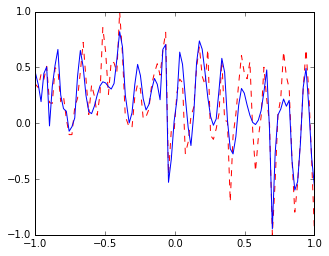

0 model =  linear_(hypot_(parabola_(sinha_(X[0])),frac2_(hypot_(linear_(hypot_(parabola_(sinha_(X[0])),X[0])),sinha_(X[0])),expl_(X[0]))))
model = linear_(w[1],w[2],hypot_(parabola_(w[3],w[4],w[5],sinha_(w[6],w[7],x)),frac2_(hypot_(linear_(w[8],w[9],hypot_(parabola_(w[10],w[11],w[12],sinha_(w[13],w[14],x)),x)),sinha_(w[15],w[16],x)),expl_(w[17],w[18],x))))
w = np.array([  0.00000000e+00,  -1.41867944e+00,   6.86283436e-01,
        -2.21037272e+00,   7.51726251e-02,   5.18464998e+00,
        -6.26329891e-02,   1.00442841e+01,  -4.38605029e-01,
         7.00716465e-01,  -2.79417426e+00,  -4.11463383e-01,
         4.93922710e+00,  -4.20587124e-02,   1.06975398e+01,
         1.70953551e-03,   1.07158996e+01,  -3.02697998e-01,
         4.71626324e-02])


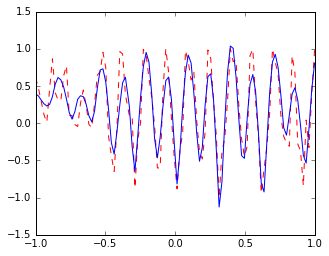

0 model =  parabola_(sinla_(sinla_(plus2_(plus2_(times2_(sinc_(normal_(sinla_(X[0]))),normal_(sinla_(X[0]))),sinc_(X[0])),frac2_(X[0],X[0])))))
model = parabola_(w[1],w[2],w[3],sinla_(w[4],w[5],sinla_(w[6],w[7],plus2_(plus2_(times2_(sinc_(w[8],w[9],normal_(w[10],w[11],sinla_(w[12],w[13],x))),normal_(w[14],w[15],sinla_(w[16],w[17],x))),sinc_(w[18],w[19],x)),frac2_(x,x)))))
w = np.array([ 0.        , -0.45092245,  0.26625803,  0.85086781, -0.04722514,
        4.0007835 ,  0.03441482,  4.23786974,  0.53072231,  1.66506484,
        0.00427825,  0.64549722, -0.01533414,  4.22303238, -0.319211  ,
        0.89871215,  0.0173534 ,  4.22662342,  0.00789757,  3.04336738])


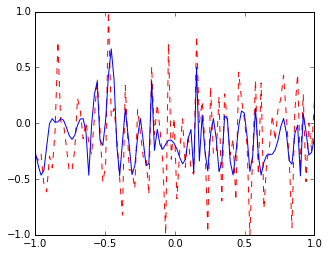

In [117]:
plot_model_activity(populationX[0], data_to_fit_pred_X, user_id, activity, number_of_file)
plot_model_activity(populationY[1], data_to_fit_pred_Y, user_id, activity, number_of_file)
plot_model_activity(populationZ[2], data_to_fit_pred_Z, user_id, activity, number_of_file)
plt.show()

label = open_apple
0 model =  times2_(parabola_(hypot_(X[0],frac2_(X[0],X[0]))),parabola_(plus2_(sinha_(hypot_(X[0],normal_(times2_(X[0],expl_(X[0]))))),sinha_(hypot_(X[0],normal_(X[0]))))))
model = times2_(parabola_(w[1],w[2],w[3],hypot_(x,frac2_(x,x))),parabola_(w[4],w[5],w[6],plus2_(sinha_(w[7],w[8],hypot_(x,normal_(w[9],w[10],times2_(x,expl_(w[11],w[12],x))))),sinha_(w[13],w[14],hypot_(x,normal_(w[15],w[16],x))))))
w = np.array([  0.        ,  -5.04149602,   3.99999998,   1.        ,
         0.05072083,   2.31902194,   3.20293194,   0.41242139,
        18.9695683 ,   0.07788874,   1.21632607,  -0.26212585,
         0.5       ,   0.60592257,  26.71714436,   0.15557056,   1.05794271])
1.328870002


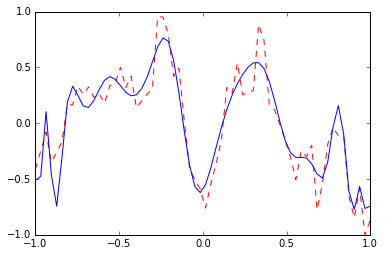

1 model =  times2_(parabola_(frac2_(X[0],hypot_(X[0],normal_(X[0])))),times2_(parabola_(X[0]),plus2_(sinla_(normal_(X[0])),times2_(sinla_(X[0]),sinha_(X[0])))))
model = times2_(parabola_(w[1],w[2],w[3],frac2_(x,hypot_(x,normal_(w[4],w[5],x)))),times2_(parabola_(w[6],w[7],w[8],x),plus2_(sinla_(w[9],w[10],normal_(w[11],w[12],x)),times2_(sinla_(w[13],w[14],x),sinha_(w[15],w[16],x)))))
w = np.array([  0.00000000e+00,  -5.56445225e+00,   9.82667959e-04,
         5.56224745e+00,   1.00000000e+00,   8.34503056e+00,
        -1.21357801e-01,  -2.80812273e-01,   9.13112509e+00,
        -1.74236418e-01,   4.99816013e+00,  -1.68814624e-01,
         1.31992017e+00,   1.27970328e-01,   4.37789482e+00,
        -3.53444560e-01,   8.32575061e+00])
1.39212642244


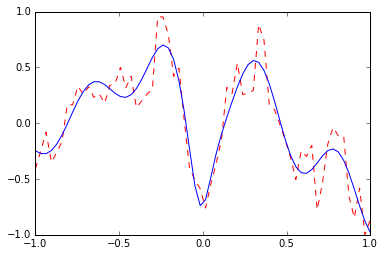

2 model =  times2_(parabola_(frac2_(X[0],X[0])),times2_(parabola_(frac2_(X[0],hypot_(X[0],normal_(X[0])))),times2_(parabola_(X[0]),plus2_(sinla_(X[0]),times2_(sinla_(X[0]),sinha_(X[0]))))))
model = times2_(parabola_(w[1],w[2],w[3],frac2_(x,x)),times2_(parabola_(w[4],w[5],w[6],frac2_(x,hypot_(x,normal_(w[7],w[8],x)))),times2_(parabola_(w[9],w[10],w[11],x),plus2_(sinla_(w[12],w[13],x),times2_(sinla_(w[14],w[15],x),sinha_(w[16],w[17],x))))))
w = np.array([ 0.        , -2.66193751, -0.71928097,  2.10591092,  0.21862337,
        2.76335617,  2.91842714,  0.38820778,  0.17228039, -1.91911936,
       -0.41524009,  2.1541468 ,  0.11247349,  5.        ,  0.15893672,
        3.50002857, -0.24966577,  6.16007846])
1.43267373007


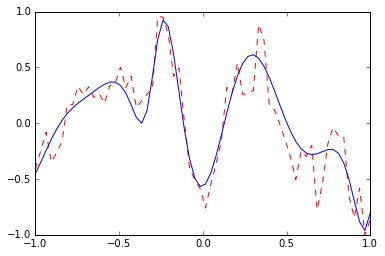

3 model =  times2_(parabola_(hypot_(X[0],frac2_(X[0],X[0]))),parabola_(plus2_(sinha_(hypot_(X[0],normal_(X[0]))),sinha_(hypot_(X[0],normal_(X[0]))))))
model = times2_(parabola_(w[1],w[2],w[3],hypot_(x,frac2_(x,x))),parabola_(w[4],w[5],w[6],plus2_(sinha_(w[7],w[8],hypot_(x,normal_(w[9],w[10],x))),sinha_(w[11],w[12],hypot_(x,normal_(w[13],w[14],x))))))
w = np.array([  0.        ,   2.09994373,  -3.99999991,   1.84562986,
       -10.05008312,   4.        ,   8.00410731,   0.89048709,
        11.81132568,  -0.30136557,   0.89624041,  -0.03193598,
        10.73664159,   0.08012854,   0.83956913])
1.44219420395


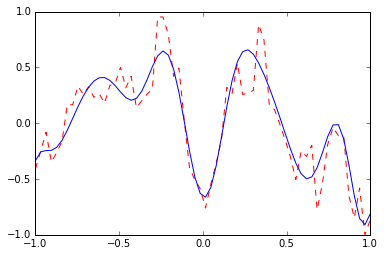

4 model =  times2_(parabola_(hypot_(X[0],sinla_(X[0]))),parabola_(plus2_(sinha_(hypot_(X[0],normal_(X[0]))),times2_(X[0],linear_(sinha_(X[0]))))))
model = times2_(parabola_(w[1],w[2],w[3],hypot_(x,sinla_(w[4],w[5],x))),parabola_(w[6],w[7],w[8],plus2_(sinha_(w[9],w[10],hypot_(x,normal_(w[11],w[12],x))),times2_(x,linear_(w[13],w[14],sinha_(w[15],w[16],x))))))
w = np.array([  0.00000000e+00,  -2.38438006e-01,   1.44172628e-02,
         1.00000000e+00,   1.21373159e-02,   4.02833439e+00,
         4.86230318e-02,   1.80022516e+00,   1.00000000e+00,
         4.22520859e-01,   1.88467859e+01,   2.07237195e-01,
         1.14423406e+00,   5.06839396e-02,   9.83086476e-01,
         7.46394308e-02,   5.10000000e+00])
1.46828694337


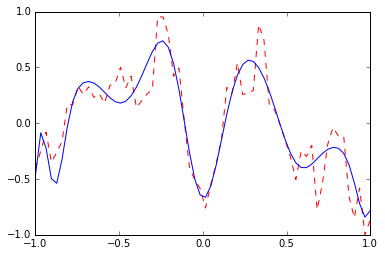

5 model =  times2_(parabola_(hypot_(X[0],frac2_(X[0],X[0]))),parabola_(plus2_(sinha_(hypot_(X[0],times2_(parabola_(X[0]),lnl_(X[0])))),times2_(X[0],parabola_(X[0])))))
model = times2_(parabola_(w[1],w[2],w[3],hypot_(x,frac2_(x,x))),parabola_(w[4],w[5],w[6],plus2_(sinha_(w[7],w[8],hypot_(x,times2_(parabola_(w[9],w[10],w[11],x),lnl_(w[12],w[13],x)))),times2_(x,parabola_(w[14],w[15],w[16],x)))))
w = np.array([  0.        ,   1.89427661,  -3.74912445,   1.78144259,
        -7.69808434,   3.99992237,  12.87604222,  -0.26734929,
         5.1       ,   0.07912379,  -1.40231694,   2.2910291 ,
         0.14576116,   0.60273558,  -0.8328813 ,  -0.2087847 ,   1.        ])
1.49149693964


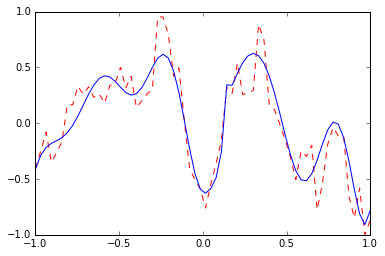

6 model =  times2_(parabola_(hypot_(X[0],frac2_(X[0],X[0]))),parabola_(plus2_(sinha_(hypot_(X[0],normal_(times2_(X[0],expl_(X[0]))))),times2_(X[0],linear_(sinha_(X[0]))))))
model = times2_(parabola_(w[1],w[2],w[3],hypot_(x,frac2_(x,x))),parabola_(w[4],w[5],w[6],plus2_(sinha_(w[7],w[8],hypot_(x,normal_(w[9],w[10],times2_(x,expl_(w[11],w[12],x))))),times2_(x,linear_(w[13],w[14],sinha_(w[15],w[16],x))))))
w = np.array([  0.        ,  -5.04151339,   3.99999918,   1.00000126,
        -0.44826104,   0.05110679,  17.11608087,   0.17901742,
        13.44683988,  -0.25121227,   1.30056835,   0.0588525 ,
         0.68746552,   0.03352874,   1.20191125,   0.2021376 ,   9.35760218])
1.50555149383


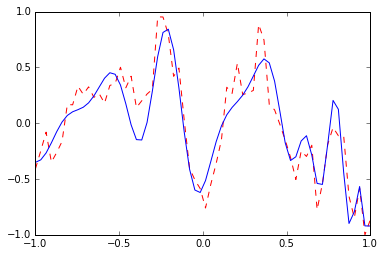

7 model =  times2_(parabola_(hypot_(X[0],frac2_(X[0],X[0]))),parabola_(plus2_(sinha_(hypot_(X[0],times2_(parabola_(X[0]),lnl_(X[0])))),times2_(X[0],parabola_(hypot_(X[0],frac2_(X[0],X[0])))))))
model = times2_(parabola_(w[1],w[2],w[3],hypot_(x,frac2_(x,x))),parabola_(w[4],w[5],w[6],plus2_(sinha_(w[7],w[8],hypot_(x,times2_(parabola_(w[9],w[10],w[11],x),lnl_(w[12],w[13],x)))),times2_(x,parabola_(w[14],w[15],w[16],hypot_(x,frac2_(x,x)))))))
w = np.array([ 0.        ,  1.82880658, -4.        ,  2.02282788, -4.1779326 ,
       -4.        ,  8.9077469 , -0.19648076,  5.74773727,  0.51852865,
       -2.55146672,  2.25006752,  0.0706934 ,  0.56882534,  3.59072575,
       -4.        ,  1.        ])
1.5217316361


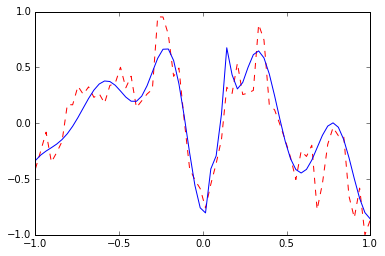

8 model =  times2_(times2_(parabola_(X[0]),lnl_(X[0])),times2_(hvs_(expl_(sinla_(sinla_(normal_(X[0]))))),linear_(X[0])))
model = times2_(times2_(parabola_(w[1],w[2],w[3],x),lnl_(w[4],w[5],x)),times2_(hvs_(w[6],expl_(w[7],w[8],sinla_(w[9],w[10],sinla_(w[11],w[12],normal_(w[13],w[14],x))))),linear_(w[15],w[16],x)))
w = np.array([  0.00000000e+00,  -2.07090865e-02,  -3.53745895e-02,
         1.61584435e+00,   3.65045924e-01,   8.20934893e-01,
        -6.13348112e-02,  -1.14656546e+00,   4.99999999e+00,
        -3.34664448e-01,   3.50000006e+00,   2.73190322e-02,
         3.50000000e+00,  -4.69215169e-03,   1.36455668e+00,
         4.45685721e-01,   1.33903531e+00])
1.54248548952


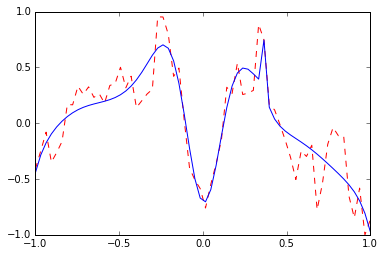

9 model =  times2_(times2_(parabola_(X[0]),plus2_(parabola_(hvs_(X[0])),sinla_(X[0]))),times2_(hvs_(expl_(sinla_(X[0]))),linear_(X[0])))
model = times2_(times2_(parabola_(w[1],w[2],w[3],x),plus2_(parabola_(w[4],w[5],w[6],hvs_(w[7],x)),sinla_(w[8],w[9],x))),times2_(hvs_(w[10],expl_(w[11],w[12],sinla_(w[13],w[14],x))),linear_(w[15],w[16],x)))
w = np.array([ 0.        ,  2.13116422,  0.23353393,  1.29423983, -0.50074039,
       -1.64051838,  2.10130074, -0.44613527, -0.03197842,  4.55864646,
       -0.92877359, -0.11906092,  2.10538831, -0.36183728,  4.00279702,
       -0.10158744,  0.8349036 ])
1.5834247729


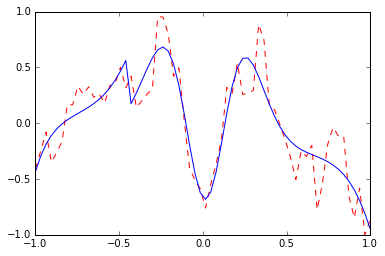

10 model =  times2_(times2_(parabola_(X[0]),parabola_(hvs_(X[0]))),times2_(hvs_(expl_(sinla_(X[0]))),lnl_(X[0])))
model = times2_(times2_(parabola_(w[1],w[2],w[3],x),parabola_(w[4],w[5],w[6],hvs_(w[7],x))),times2_(hvs_(w[8],expl_(w[9],w[10],sinla_(w[11],w[12],x))),lnl_(w[13],w[14],x)))
w = np.array([ 0.        , -0.02854966, -0.05755067,  1.88993515, -1.96954994,
        4.        ,  1.        , -0.27105842,  0.06566665, -0.53275762,
        2.06503364, -0.42724478,  3.77148052,  0.41276477,  0.83449914])
1.61911459082


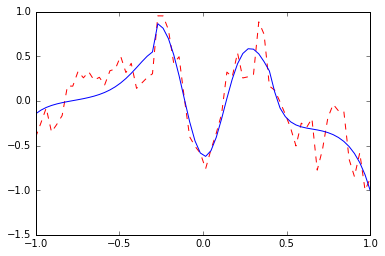

11 model =  times2_(times2_(parabola_(X[0]),lnl_(X[0])),times2_(hvs_(expl_(sinla_(X[0]))),linear_(X[0])))
model = times2_(times2_(parabola_(w[1],w[2],w[3],x),lnl_(w[4],w[5],x)),times2_(hvs_(w[6],expl_(w[7],w[8],sinla_(w[9],w[10],x))),linear_(w[11],w[12],x)))
w = np.array([ 0.        , -0.03799917, -0.08390418,  2.56253066,  0.36491974,
        0.80350642, -0.49497199, -0.92993909,  2.02083099,  1.17392258,
        4.09966857,  0.41774229,  1.43462047])
1.62106442074


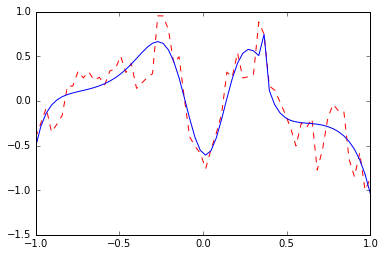

12 model =  times2_(times2_(parabola_(X[0]),parabola_(X[0])),times2_(parabola_(X[0]),hvs_(expl_(sinla_(X[0])))))
model = times2_(times2_(parabola_(w[1],w[2],w[3],x),parabola_(w[4],w[5],w[6],x)),times2_(parabola_(w[7],w[8],w[9],x),hvs_(w[10],expl_(w[11],w[12],sinla_(w[13],w[14],x)))))
w = np.array([ 0.        , -0.82822584,  0.87188241,  2.15132846, -2.56915862,
       -0.04454771,  2.14968868, -0.03714002, -0.09296985,  2.72279035,
        0.02391326, -0.08983502,  1.98067345, -0.30404627,  4.29305143])
1.65775674732


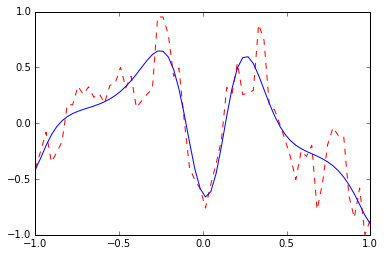

13 model =  plus2_(frac2_(X[0],X[0]),linear_(times2_(sinla_(normal_(X[0])),frac2_(times2_(X[0],sinla_(X[0])),parabola_(normal_(sinha_(X[0])))))))
model = plus2_(frac2_(x,x),linear_(w[1],w[2],times2_(sinla_(w[3],w[4],normal_(w[5],w[6],x)),frac2_(times2_(x,sinla_(w[7],w[8],x)),parabola_(w[9],w[10],w[11],normal_(w[12],w[13],sinha_(w[14],w[15],x)))))))
w = np.array([ 0.        ,  6.51085292,  0.2       ,  0.06159396,  3.5       ,
        0.74113431,  1.03215897, -0.08343893,  3.8214792 , -0.47325999,
        3.99689924,  1.24517278,  0.06203339,  7.28169721,  0.07541783,
        5.86879155])
1.65694105028


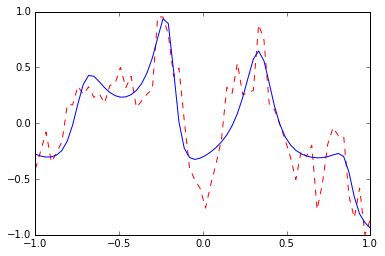

14 model =  times2_(parabola_(hypot_(X[0],frac2_(X[0],X[0]))),parabola_(plus2_(hypot_(X[0],normal_(X[0])),times2_(X[0],linear_(sinha_(X[0]))))))
model = times2_(parabola_(w[1],w[2],w[3],hypot_(x,frac2_(x,x))),parabola_(w[4],w[5],w[6],plus2_(hypot_(x,normal_(w[7],w[8],x)),times2_(x,linear_(w[9],w[10],sinha_(w[11],w[12],x))))))
w = np.array([ 0.        , -4.93971627,  2.62211968,  1.00000069, -1.16646734,
       -0.97148461,  1.00000032, -0.07730587,  0.54104516, -0.68828853,
        1.01712051, -0.34552195,  8.22002851])
1.66564189028


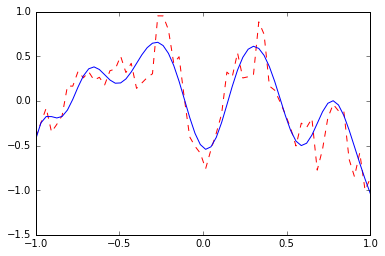

15 model =  times2_(parabola_(X[0]),parabola_(plus2_(sinha_(hypot_(X[0],normal_(X[0]))),times2_(X[0],linear_(sinha_(X[0]))))))
model = times2_(parabola_(w[1],w[2],w[3],x),parabola_(w[4],w[5],w[6],plus2_(sinha_(w[7],w[8],hypot_(x,normal_(w[9],w[10],x))),times2_(x,linear_(w[11],w[12],sinha_(w[13],w[14],x))))))
w = np.array([  0.00000000e+00,   4.51733211e+00,   4.00000000e+00,
         1.00000000e+00,   2.21662185e+00,   3.57935673e+00,
         1.00000000e+00,  -5.25136324e-01,   7.21037630e+00,
         1.14645257e-02,   1.08574939e+00,  -4.12850685e-03,
         2.00000000e-01,   1.59602876e-02,   9.36386414e+00])
1.67506098993


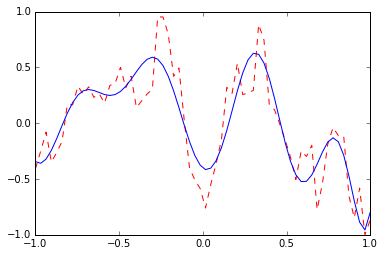

16 model =  times2_(parabola_(X[0]),parabola_(plus2_(sinha_(hypot_(normal_(X[0]),plus2_(bump_(frac2_(X[0],X[0])),X[0]))),times2_(X[0],linear_(sinha_(X[0]))))))
model = times2_(parabola_(w[1],w[2],w[3],x),parabola_(w[4],w[5],w[6],plus2_(sinha_(w[7],w[8],hypot_(normal_(w[9],w[10],x),plus2_(bump_(w[11],w[12],frac2_(x,x)),x))),times2_(x,linear_(w[13],w[14],sinha_(w[15],w[16],x))))))
w = np.array([  0.00000000e+00,   4.51738237e+00,   4.00000000e+00,
         1.00000000e+00,   2.21661063e+00,   3.57934096e+00,
         1.00000000e+00,  -5.25136522e-01,   7.21037671e+00,
         1.14642782e-02,   1.08574955e+00,   1.72957585e-01,
        -6.29279057e-01,  -4.12460810e-03,   2.00000000e-01,
         1.59600865e-02,   9.36386570e+00])
1.67506099004


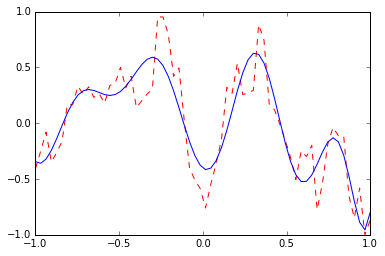

In [5]:
%run ValidateFinalModel.py 'specific_segment' 'open_apple' 19

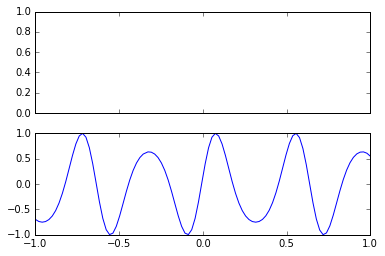

In [115]:
#w = [0.75945128579027477, 1.8257602509301276, 0.47967188925467663, 1.6194614328457326, 0.4164207414652753, 0.73103167165388483, 0.98798319227210962, 0.98412347875238682]

model = "times2_(parabola_(w[1],w[2],w[3],linear_(w[4],w[5],sinla_(w[6],w[7],sinla_(w[8],w[9],x)))),parabola_(w[10],w[11],w[12],minus2_(sinc_(w[13],w[14],sinc_(w[15],w[16],sinla_(w[17],w[18],x))),sinla_(w[19],w[20],sinla_(w[21],w[22],sinc_(w[23],w[24],x))))))"
w = np.array([  0.00000000e+00,   8.27068339e-03,   2.29037810e-01,
         1.69862602e+00,  -1.14152033e-01,   5.24803063e-01,
        -2.05302657e-02,   3.91107266e+00,  -3.26320074e-03,
         4.92935627e+00,  -1.84818651e+00,   4.62433951e-01,
         1.32186039e+00,   4.49445647e-01,   3.07689116e+00,
        -6.64554172e-02,   2.40328487e+00,  -7.28895081e-04,
         3.90981760e+00,  -1.25690198e-01,   4.43879460e+00,
         6.32733267e-02,   3.87888037e+00,  -4.81648550e-02,
         2.88440391e+00])

x = data_to_fit_pred_X[:,1]
#plt.plot(x,x-normal_(w[0],w[1],normal_(w[2],w[3],normal_(w[4],w[5],normal_(w[6],w[7],x)))))
#model = 'linear_(w[0],w[1],normal_(w[2],w[3],normal_(w[4],w[5],sinla_(w[6],w[7],sinha_(w[8],w[9],x)))))'
#model = 'parabola_(w[0],w[1],w[2],normal_(w[3],w[4],inv_(sinla_(w[5],w[6],normal_(w[7],w[8],x)))))'
model = "sinla_(w[6],w[7],sinla_(w[8],w[9],x))"
#plt.plot(x,normal_(w[4],w[5],sinla_(w[6],w[7],normal_(w[8],w[9],x))))
f, axarr = plt.subplots(2, sharex=True)
axarr[1].plot(x, sinla_(w[6],w[7],sinla_(w[8],w[9],x)))

plt.show()

In [23]:
from pyparsing import nestedExpr
txt = "(linear_(linear_(normal_(normal_(sinha_(X[0]))))))"
nst = nestedExpr('(',')').parseString(txt).asList()
import itertools
merged = list(itertools.chain(*nst))
merged

(linear_&linear_&normal_&normal_&sinha_


['linear_', ['linear_', ['normal_', ['normal_', ['sinha_', ['X[0]']]]]]]

In [39]:
from sklearn import datasets
X, y = datasets.make_regression(int(1e5))
print("{:,}".format(X.nbytes))

80,000,000


** Sort rules in 'data/rules.txt' for convenience **

In [26]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/rules.txt','r')
file[-1].extend('\n')
lines = file.readlines()
lines_sorted = sorted(lines)
file.close()
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/rules.txt','w')
file.write(''.join(lines_sorted))
file.close()

['atana_(linear_(x0)) atana_(x0)\n', 'atana_(mult_(x0)) atana_(x0)\n', 'atana_(plus2_(x0,x0)) atana_(x0)\n', 'atana_(plus_(x0)) atana_(x0)\n', 'expl_(linear_(x0)) expl_(x0)\n', 'expl_(lnl_(x0)) linear_(x0)\n', 'expl_(mult_(x0)) expl_(x0)\n', 'expl_(plus2_(x0,x0)) expl_(x0)\n', 'expl_(plus_(x0)) expl_(x0)\n', 'hyperbola_(inv_(x0)) mult_(x0)\n', 'inv_(expl_(x0)) expl_(x0)\n', 'inv_(hyperbola_(x0)) mult_(x0)\n', 'inv_(inv_(x0)) x0\n', 'inv_(mult_(x0)) inv_(x0)\n', 'linear_(linear_(x0)) linear_(x0)\n', 'linear_(mult_(x0)) linear_(x0)\n', 'linear_(parabola_(x0)) parabola_(x0)\n', 'linear_(plus_(x0)) linear_(x0)\n', 'lnl_(expl_(x0)) linear_(x0)\n', 'lnl_(linear_(x0)) lnl_(x0)\n', 'lnl_(mult_(x0)) lnl_(x0)\n', 'lnl_(normal_(x0)) parabola_(x0)\n', 'lnl_(plus2_(x0,x0)) lnl_(x0)\n', 'lnl_(plus_(x0)) lnl_(x0)\n', 'mult_(hyperbola_(x0)) hyperbola_(x0)\n', 'mult_(hyperbola_(x0)) mult_(x0)\n', 'mult_(linear_(x0)) linear_(x0)\n', 'mult_(mult_(x0)) mult_(x0)\n', 'mult_(parabola_(x0)) parabola_(x0)\n',

In [ ]:
ax2 + bx + c -> 2ax + b = 0 -> x0 = -b  in [-2a,2a]

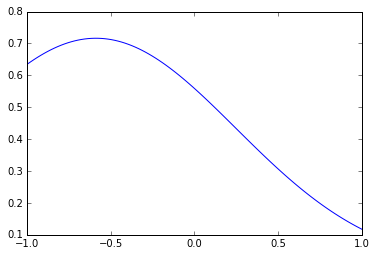

In [52]:
def cosh_(w0, w1, x):
    cosh_.NumParam = 2
    cosh_.NumVars = 1

    return np.cosh(x * (0.5 + abs(w1)) + w0)

x = np.linspace(-1,1,100)
plt.plot(x,normal_(w[8],w[9],x))
plt.show()

In [24]:
a = ([],[])

[1, 2, 2, 3, 4]

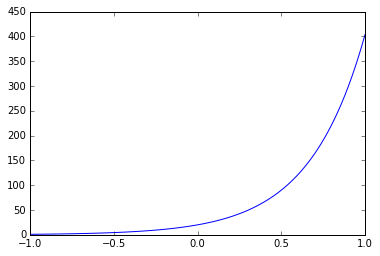

In [29]:
def expl_(w0, w1, x):
    expl_.NumParam = 2
    expl_.NumVars = 1
    return np.exp(x * w1 + w0)
w0 = 3
w1 = 3
x = np.linspace(-1,1,100)
y = expl_(w0, w1, x)
plt.plot(x,y)

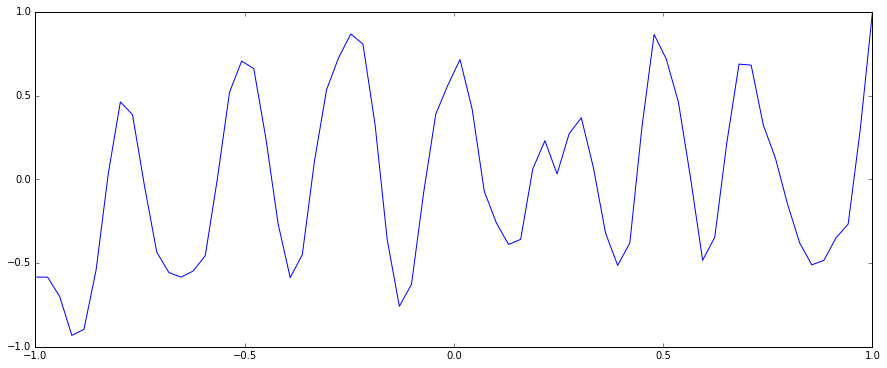

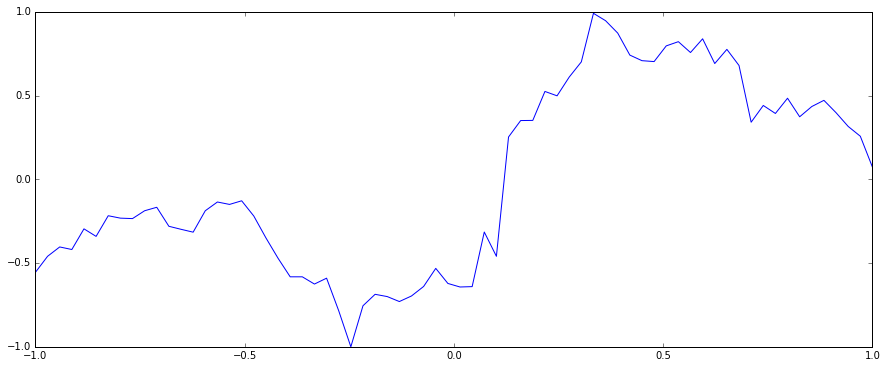

In [40]:
plt.figure(figsize = (15,6))

b = np.loadtxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/heart_rate.txt')
segment = 0
length = 70
x = np.linspace(-1,1,length)
y = b[segment*length:(segment + 1)*length]
y = y - np.mean(y, axis = 0)
y = np.divide(y, np.max(np.abs(y), axis=0))
plt.plot(x, y)
plt.figure(figsize = (15,6))
b = np.loadtxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/open_apple.txt')
segment = 0
length = 70
x = np.linspace(-1,1,length)
y = b[segment*length:(segment + 1)*length]
y = y - np.mean(y, axis = 0)
y = np.divide(y, np.max(np.abs(y), axis=0))
plt.plot(x, y)

** Write specified number of samples to ts_processing text-files **

In [122]:
ts_labels = ['chest_volume', 'heart_rate', 'oxygen_concentration', 'open_apple']
file_path = 'ts_processing/'
number_of_rows = 6400
for ts_label in ts_labels:
    array = np.loadtxt(file_path + ts_label + '_full.txt')
    np.savetxt(file_path + ts_label + '.txt', array[0:number_of_rows], fmt = '%.3f')

In [123]:
dataset = pd.read_csv('/home/kuluandrej/cafedra2015-2016/Experiments on Machine Learning/Datasets/WIKI-AAPL.csv')
time_series = dataset['Open']
backup_time_series = time_series

In [48]:
import re
b = 'plus2_(lnl_(linear_(x0)),atana_(linear_(x0)))'
re.sub(r'x(\d+)', r'X[\1]', b)
handle = re.sub(r'X\[(\d+)\]', r'x\1', 'x0')
handle

'x0'

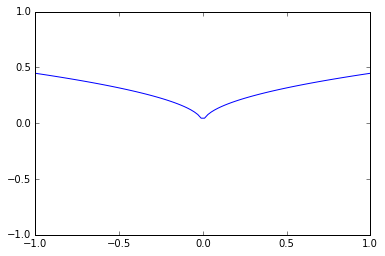

In [15]:
x = np.linspace(-1,1,100)
w0 = 0
w1 = 0.2

def sqrtl_(w0, w1, x):
    sqrtl_.NumParam = 2
    sqrtl_.NumVars = 1

    return np.sqrt(np.abs(x * w1 + w0))

plt.plot(x, sqrtl_(w0, w1, x))
plt.axis([-1, 1, -1, 1])
plt.show()

In [25]:
files_path = 'ts_processing/'
ts_labels = ['chest_volume', 'heart_rate', 'oxygen_concentration']
ts_labels = sorted(ts_labels)

number_ts_pieces = len(os.listdir(files_path)) / len(ts_labels)
# if the number is not divided 
if abs(number_ts_pieces - round(number_ts_pieces)) > 0:
    print('ERROR: invalid number of files in ', files_path)
else:
    number_ts_pieces = int(number_ts_pieces)    

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]

file_names = sorted(os.listdir(files_path), key=natural_keys)

ERROR: invalid number of files in  ts_processing/


In [26]:
# set of labels of ts to classify
# labels = chest_volume, heart_rate, oxygen_concentration
labels = ['chest_volume', 'heart_rate', 'oxygen_concentration']
# locations of the ts
root_path = '/MVR_py/ts_processing/'
# extension of files containing data about ts
extension = '.txt'
# folder for output files
where_to_store_models = 'collected_models2/'
# specifies number of segments for ts to be split on
number_of_segments = 340

def retrieve_ts(label):
    
    dataset_filename     = '/data/data_to_fit.txt'
    init_models_filename = '/data/init_models.txt'
    
    
    
    DATA_LOCAL_PATH = root_path
    script_dir = os.path.dirname('__file__')
    parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
    DATA_FULL_PATH = parent_dir + DATA_LOCAL_PATH + label + extension
    # retrieve the data to fit from the specified file
    data_to_fit = np.loadtxt(DATA_FULL_PATH, delimiter = ',')
    data_to_fit = np.vstack((data_to_fit, np.linspace(0,1, len(data_to_fit)))).T
    return data_to_fit



In [27]:
def get_segment_of_ts(data, index_of_segment, length_of_segments):
    return data[index_of_segment * length_of_segments : (index_of_segment + 1) * length_of_segments, :]

ts_label = oxygen_concentration ; index_of_segment = 0


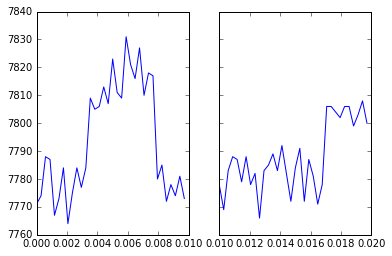

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

index_of_segment = 0
data = retrieve_ts('oxygen_concentration')
segment = get_segment_of_ts(data, 0, 34)
X = segment[:,1]
y = segment[:,0]

ax1.plot(X,y)

index_of_segment = 0

print("ts_label =", 'oxygen_concentration', "; index_of_segment =", index_of_segment)

data = retrieve_ts('oxygen_concentration')
segment = get_segment_of_ts(data, 1, 34)
X = segment[:,1]
y = segment[:,0]
ax2.plot(X,y)
plt.show()



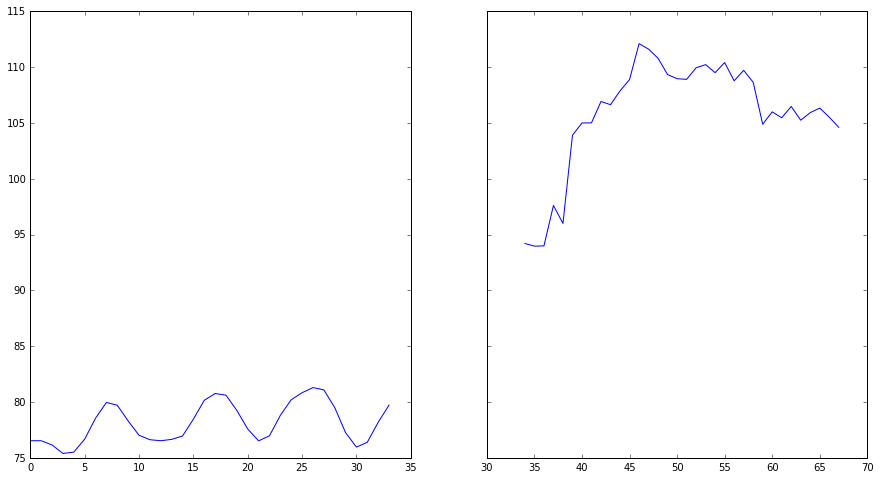

In [41]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/heart_rate.txt', 'r')
data = np.loadtxt(file) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(15)
num_seg = 0
num_rows = 34
ax1.plot(data[num_seg * num_rows : num_seg * num_rows + num_rows,])
num_seg = 1
ax2.plot(data[num_seg * num_rows : num_seg * num_rows + num_rows,])


In [28]:
np.savetxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/open_apple_full.txt', backup_time_series[:], fmt = '%.4f')

ts_label = chest_volume ; index_of_segment = 0


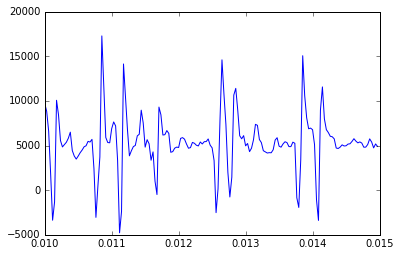

In [51]:
index_of_segment = 0
print("ts_label =", ts_labels[0], "; index_of_segment =", index_of_segment)
data = retrieve_ts(ts_labels[0])
segment = get_segment_of_ts(data, 2, int(data.shape[0] / 200))
X = segment[:,1]
y = segment[:,0]
plt.plot(X,y)
plt.show()

In [5]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]

files_path = 'populations/first_segments2/'
file_names = sorted(os.listdir(files_path), key=natural_keys)
files_path_dest = 'populations/first_segments3/'

if not os.path.isdir(files_path_dest):
    os.makedirs(files_path_dest)

    
for file in file_names:
    number_of_file = int(file[:-4].split('_')[-1])
    if number_of_file >= 51:
        os.rename(files_path + file, files_path_dest + file)

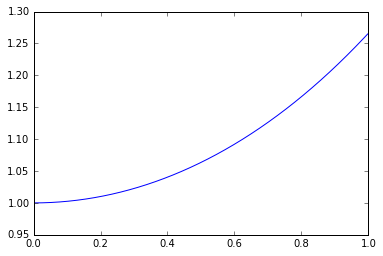

In [33]:
x = np.arange(0,1,.002)
y = np.i0(x)
plt.plot(x,y)

Script dealing with data removing from 'init_models'

In [35]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/init_models.txt', 'r')
lines = file.readlines()
file.close()
file = open('/home/kuluandrej/cafedra2015-2016/Experiments on Machine Learning/Datasets/WIKI-AAPL.csv', 'w')
file_dest = open()
required_rows = 5000
for i in range(required_rows):
    file.write(lines[i])
file.close()